In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.nn import init
import matplotlib.pyplot as plt
from torch.autograd import Variable
import torchvision.models as models
from functools import reduce
from operator import __or__
from torch.utils.data.sampler import SubsetRandomSampler
from torchvision.datasets import MNIST
from torchvision import datasets, transforms

In [2]:
bs = 64

# MNIST Dataset
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=(0.5, 0.5, 0.5), std=(0.5, 0.5, 0.5))])

train_dataset = datasets.MNIST(root='./', train=True, transform=transform, download=True)
test_dataset = datasets.MNIST(root='./', train=False, transform=transform, download=False)

# Data Loader (Input Pipeline)
train_loader = torch.utils.data.DataLoader(dataset=train_dataset, batch_size=bs, shuffle=True)
test_loader = torch.utils.data.DataLoader(dataset=test_dataset, batch_size=bs, shuffle=False)

In [3]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

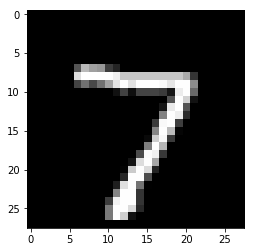

In [4]:
plt.imshow(next(iter(test_loader))[0][0].view(28,28), cmap='gray')

In [5]:
def normal_init(m, mean, std):
    if isinstance(m, nn.ConvTranspose2d) or isinstance(m, nn.Conv2d):
        m.weight.data.normal_(mean, std)
        m.bias.data.zero_()

In [6]:
class Generator(nn.Module):
    def __init__(self, in_dim=100, out_dim=784, d=128):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(in_features=in_dim, out_features=256),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(in_features=256, out_features=256),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(in_features=256, out_features=256),
                                 nn.LeakyReLU(0.2),
                                 nn.Linear(in_features=256, out_features=out_dim),
                                 nn.Tanh())

#         self.net = nn.Sequential(nn.ConvTranspose2d(in_channels=100, out_channels=d*4, kernel_size=4, stride=1, padding=0),
#                          nn.BatchNorm2d(d*4),
#                          nn.ReLU(),
#                          nn.ConvTranspose2d(in_channels=d*4, out_channels=d*2, kernel_size=4, stride=2, padding=1),
#                          nn.BatchNorm2d(d*2),
#                          nn.ReLU(),
#                          nn.ConvTranspose2d(in_channels=d*2, out_channels=d, kernel_size=3, stride=2, padding=1),
#                          nn.BatchNorm2d(d),
#                          nn.ReLU(),
#                          nn.ConvTranspose2d(in_channels=d, out_channels=1, kernel_size=2, stride=2, padding=1),
#                          nn.Tanh())
    
    def forward(self,x):
        return self.net(x)
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)

In [7]:
class Discriminator(nn.Module):
    def __init__(self, in_dim=784, d=128):
        super().__init__()
        self.net = nn.Sequential(nn.Linear(in_features=in_dim, out_features=256),
                                 nn.LeakyReLU(0.2),
                                 nn.Dropout(0.3),
                                 nn.Linear(in_features=256, out_features=256),
                                 nn.LeakyReLU(0.2),
                                 nn.Dropout(0.3),
                                 nn.Linear(in_features=256, out_features=256),
                                 nn.LeakyReLU(0.2),
                                 nn.Dropout(0.3),
                                 nn.Linear(in_features=256, out_features=1),
                                 nn.Sigmoid())
#         self.net = nn.Sequential(nn.Conv2d(1, d, 2, 2, 1),
#                                  nn.LeakyReLU(0.2),
#                                  nn.Conv2d(d, d*2, 3, 2, 1),
#                                  nn.BatchNorm2d(d*2),
#                                  nn.LeakyReLU(0.2),
#                                  nn.Conv2d(d*2, d*4, 4, 2, 1),
#                                  nn.BatchNorm2d(d*4),
#                                  nn.LeakyReLU(0.2),
#                                  nn.Conv2d(d*4, 1, 4, 1, 0),
#                                  nn.Sigmoid())
        
    def forward(self,x):        
        return self.net(x)
    
    # weight_init
    def weight_init(self, mean, std):
        for m in self._modules:
            normal_init(self._modules[m], mean, std)
    
    def load(self, backup):
        for m_from, m_to in zip(backup.modules(), self.modules()):
             if isinstance(m_to, nn.Linear):
                m_to.weight.data = m_from.weight.data.clone()
                if m_to.bias is not None:
                    m_to.bias.data = m_from.bias.data.clone()

In [8]:
generator = Generator()
discriminator = Discriminator()

# generator.weight_init(mean=0.0, std=0.02)
# discriminator.weight_init(mean=0.0, std=0.02)

generator = generator.to(device)
discriminator = discriminator.to(device)
# classifier = models.resnet18()

In [9]:
# x = torch.rand(1,100,1,1).to(device)
x = torch.rand(2,100).to(device)
generator(x).shape

torch.Size([2, 784])

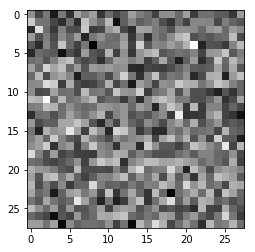

In [10]:
# plt.imshow(generator(x)[0,0,:,:].cpu().detach(), cmap='gray')
plt.imshow(generator(x).cpu().detach().view(-1,28,28)[0], cmap='gray')

In [11]:
discriminator(generator(x))

tensor([[0.4922],
        [0.5005]], device='cuda:0', grad_fn=<SigmoidBackward>)

In [12]:
optimizerD = torch.optim.Adam(discriminator.parameters(), lr=0.0002, betas=(0.9, 0.999))
optimizerG = torch.optim.Adam(generator.parameters(), lr=0.0002, betas=(0.9, 0.999))

In [13]:
def to_variable(x):
    '''
    convert a tensor to a variable
    with gradient tracking
    '''
    x = x.to(device)
    return Variable(x)

In [ ]:
criterion = nn.BCELoss()
NUM_EPOCH = 100

def train():
    loss_g, loss_d = [], []
    for epoch in range(NUM_EPOCH):
        
        for idx, batch_data in enumerate(train_loader):

            batch_size = batch_data[0].shape[0]
            
            fake_labels = to_variable(torch.zeros(batch_size, 1))
            true_labels = to_variable(1*torch.ones(batch_size, 1))
           
            
            
            #========================== Train discriminator on real data ==========================
            discriminator.zero_grad()
            batch_images = to_variable(batch_data[0].view(batch_size, -1))
            outputs_real = discriminator(batch_images)
            lossD_real = criterion(outputs_real, true_labels)

            lossD_real.backward()

            
            #========================== Train discriminator on fake data ==========================
            
#             noise = to_variable(torch.randn(batch_size, 100, 1, 1))
            noise = to_variable(torch.randn(batch_size, 100))
            fake_images = generator(noise)
            outputs_fake_d = discriminator(fake_images.detach())
            lossD_fake = criterion(outputs_fake_d, fake_labels)

            lossD_fake.backward()
            

            lossD = lossD_fake + lossD_real
#             lossD.backward()
            optimizerD.step()
            
            #========================== Train generator ==========================
            generator.zero_grad()
#             noise = to_variable(torch.randn(batch_size, 100, 1, 1))
#             fake_images = generator(noise)
            outputs_fake_g = discriminator(fake_images)
            lossG =  criterion(outputs_fake_g, true_labels)
#             lossG = -torch.log(outputs).mean()
            
            lossG.backward()
#             print(noise.grad)
            loss_d.append(lossD.item())
            loss_g.append(lossG.item())
#             print(generator.net[0].weight.grad.mean())
            optimizerG.step()
        print("Epoch: ", epoch, ", Gloss: ", loss_g[-1], ", Dloss: ", loss_d[-1])
            

In [15]:
train()

Epoch:  0 , Gloss:  2.2905654907226562 , Dloss:  0.5978566408157349
Epoch:  1 , Gloss:  3.968438148498535 , Dloss:  0.7621498703956604
Epoch:  2 , Gloss:  2.2363321781158447 , Dloss:  0.5426040291786194
Epoch:  3 , Gloss:  1.9793226718902588 , Dloss:  0.8098795413970947
Epoch:  4 , Gloss:  1.093970775604248 , Dloss:  1.023723840713501
Epoch:  5 , Gloss:  1.8367056846618652 , Dloss:  0.8039944767951965
Epoch:  6 , Gloss:  2.001063346862793 , Dloss:  0.542405903339386
Epoch:  7 , Gloss:  1.7423176765441895 , Dloss:  0.4797274172306061
Epoch:  8 , Gloss:  1.838382363319397 , Dloss:  1.1375460624694824
Epoch:  9 , Gloss:  1.8962247371673584 , Dloss:  1.180426001548767
Epoch:  10 , Gloss:  1.7354989051818848 , Dloss:  0.7028974294662476
Epoch:  11 , Gloss:  2.2462310791015625 , Dloss:  0.6771985292434692
Epoch:  12 , Gloss:  1.6931462287902832 , Dloss:  0.7164724469184875
Epoch:  13 , Gloss:  1.4510550498962402 , Dloss:  1.0208961963653564
Epoch:  14 , Gloss:  1.4341319799423218 , Dloss:  0

KeyboardInterrupt: 

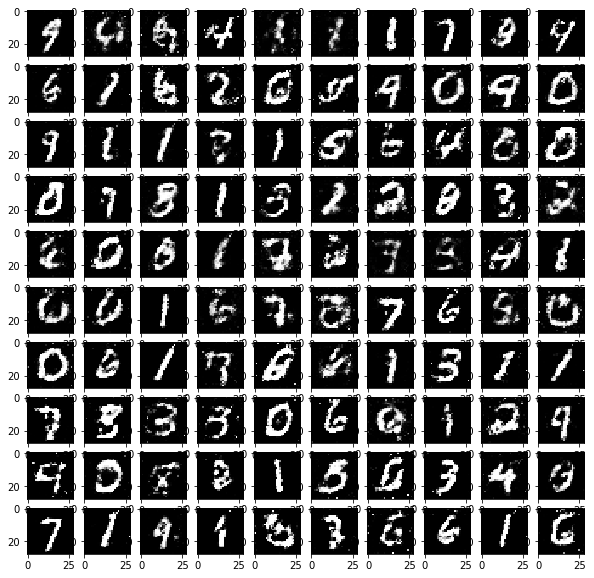

In [19]:
# x = torch.rand(100,100,1,1).to(device)
x = torch.randn(100,100).to(device)

plt.figure(figsize=(10,10))

for i in range(10):
    for j in range(10):
        plt.subplot(10,10,10*i+j+1)
        plt.imshow(generator(x)[10*i+j].view(28,28).cpu().detach(), cmap='gray')